In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
import shap
from tqdm import tqdm
import joblib

In [2]:
def predict_classes(probabilities, class_names, threshold=0.5):
    """
    Predict class names based on probabilities and a custom threshold for class 1.

    Args:
        probabilities (list of list of floats): List of probability pairs, one per sample.
        class_names (list of str): Class names corresponding to indices [0, 1].
        threshold (float): Threshold for assigning class 1.

    Returns:
        list of str: Predicted class names.
    """
    predictions = []
    for prob in probabilities:
        if prob[1] >= threshold:
            predictions.append(class_names[1])
        else:
            predictions.append(class_names[0])
    return predictions

In [3]:
def atom_dict_to_bitvector(atom_dict):
    # Total number of elements in the periodic table (approximate upper bound)
    num_elements = 118
    
    # Atomic numbers corresponding to element symbols (simplified for common elements)
    periodic_table = {
        "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8,
        "F": 9, "Ne": 10, "Na": 11, "Mg": 12, "Al": 13, "Si": 14, "P": 15,
        "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20, "Sc": 21, "Ti": 22,
        "V": 23, "Cr": 24, "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29,
        "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36,
        "Rb": 37, "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43,
        "Ru": 44, "Rh": 45, "Pd": 46, "Ag": 47, "Cd": 48, "In": 49, "Sn": 50,
        "Sb": 51, "Te": 52, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56, "La": 57,
        "Ce": 58, "Pr": 59, "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64,
        "Tb": 65, "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71,
        "Hf": 72, "Ta": 73, "W": 74, "Re": 75, "Os": 76, "Ir": 77, "Pt": 78,
        "Au": 79, "Hg": 80, "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84, "At": 85,
        "Rn": 86, "Fr": 87, "Ra": 88, "Ac": 89, "Th": 90, "Pa": 91, "U": 92,
        "Np": 93, "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99,
        "Fm": 100, "Md": 101, "No": 102, "Lr": 103, "Rf": 104, "Db": 105, "Sg": 106,
        "Bh": 107, "Hs": 108, "Mt": 109, "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113,
        "Fl": 114, "Mc": 115, "Lv": 116, "Ts": 117, "Og": 118
    }
    
    # Calculate the total number of atoms
    total_atoms = sum(atom_dict.values())
    
    # Create a zero vector with length equal to the number of elements in the periodic table
    bitvector = np.zeros(num_elements)
    
    # Populate bit vector with normalized values based on atomic number
    for element, count in atom_dict.items():
        atomic_number = periodic_table.get(element)
        if atomic_number:
            bitvector[atomic_number - 1] = count / total_atoms
#             bitvector[atomic_number - 1] = 1
    
    return bitvector.tolist()

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df["atom_counts"] = df["atom_counts"].apply(eval)

In [6]:
df

,Unnamed: 0.1,Unnamed: 0,atom_counts,puckering
0,0,0,"{'Ba': 2, 'Sb': 1}",Puckered
1,1,1,"{'Tc': 1, 'Te': 2}",Puckered
2,2,2,"{'Au': 1, 'Br': 1}",Puckered
3,3,3,"{'Ti': 3, 'Se': 2}",Puckered
4,4,4,"{'Au': 2, 'Se': 2}",Puckered
...,...,...,...,...
4067,4067,4067,"{'Sn': 2, 'N': 2}",Puckered
4068,4068,4068,"{'Sn': 1, 'Bi': 1}",Puckered
4069,4069,4069,"{'C': 2, 'Sb': 2}",Puckered
4070,4070,4070,"{'Ba': 2, 'P': 6}",Puckered


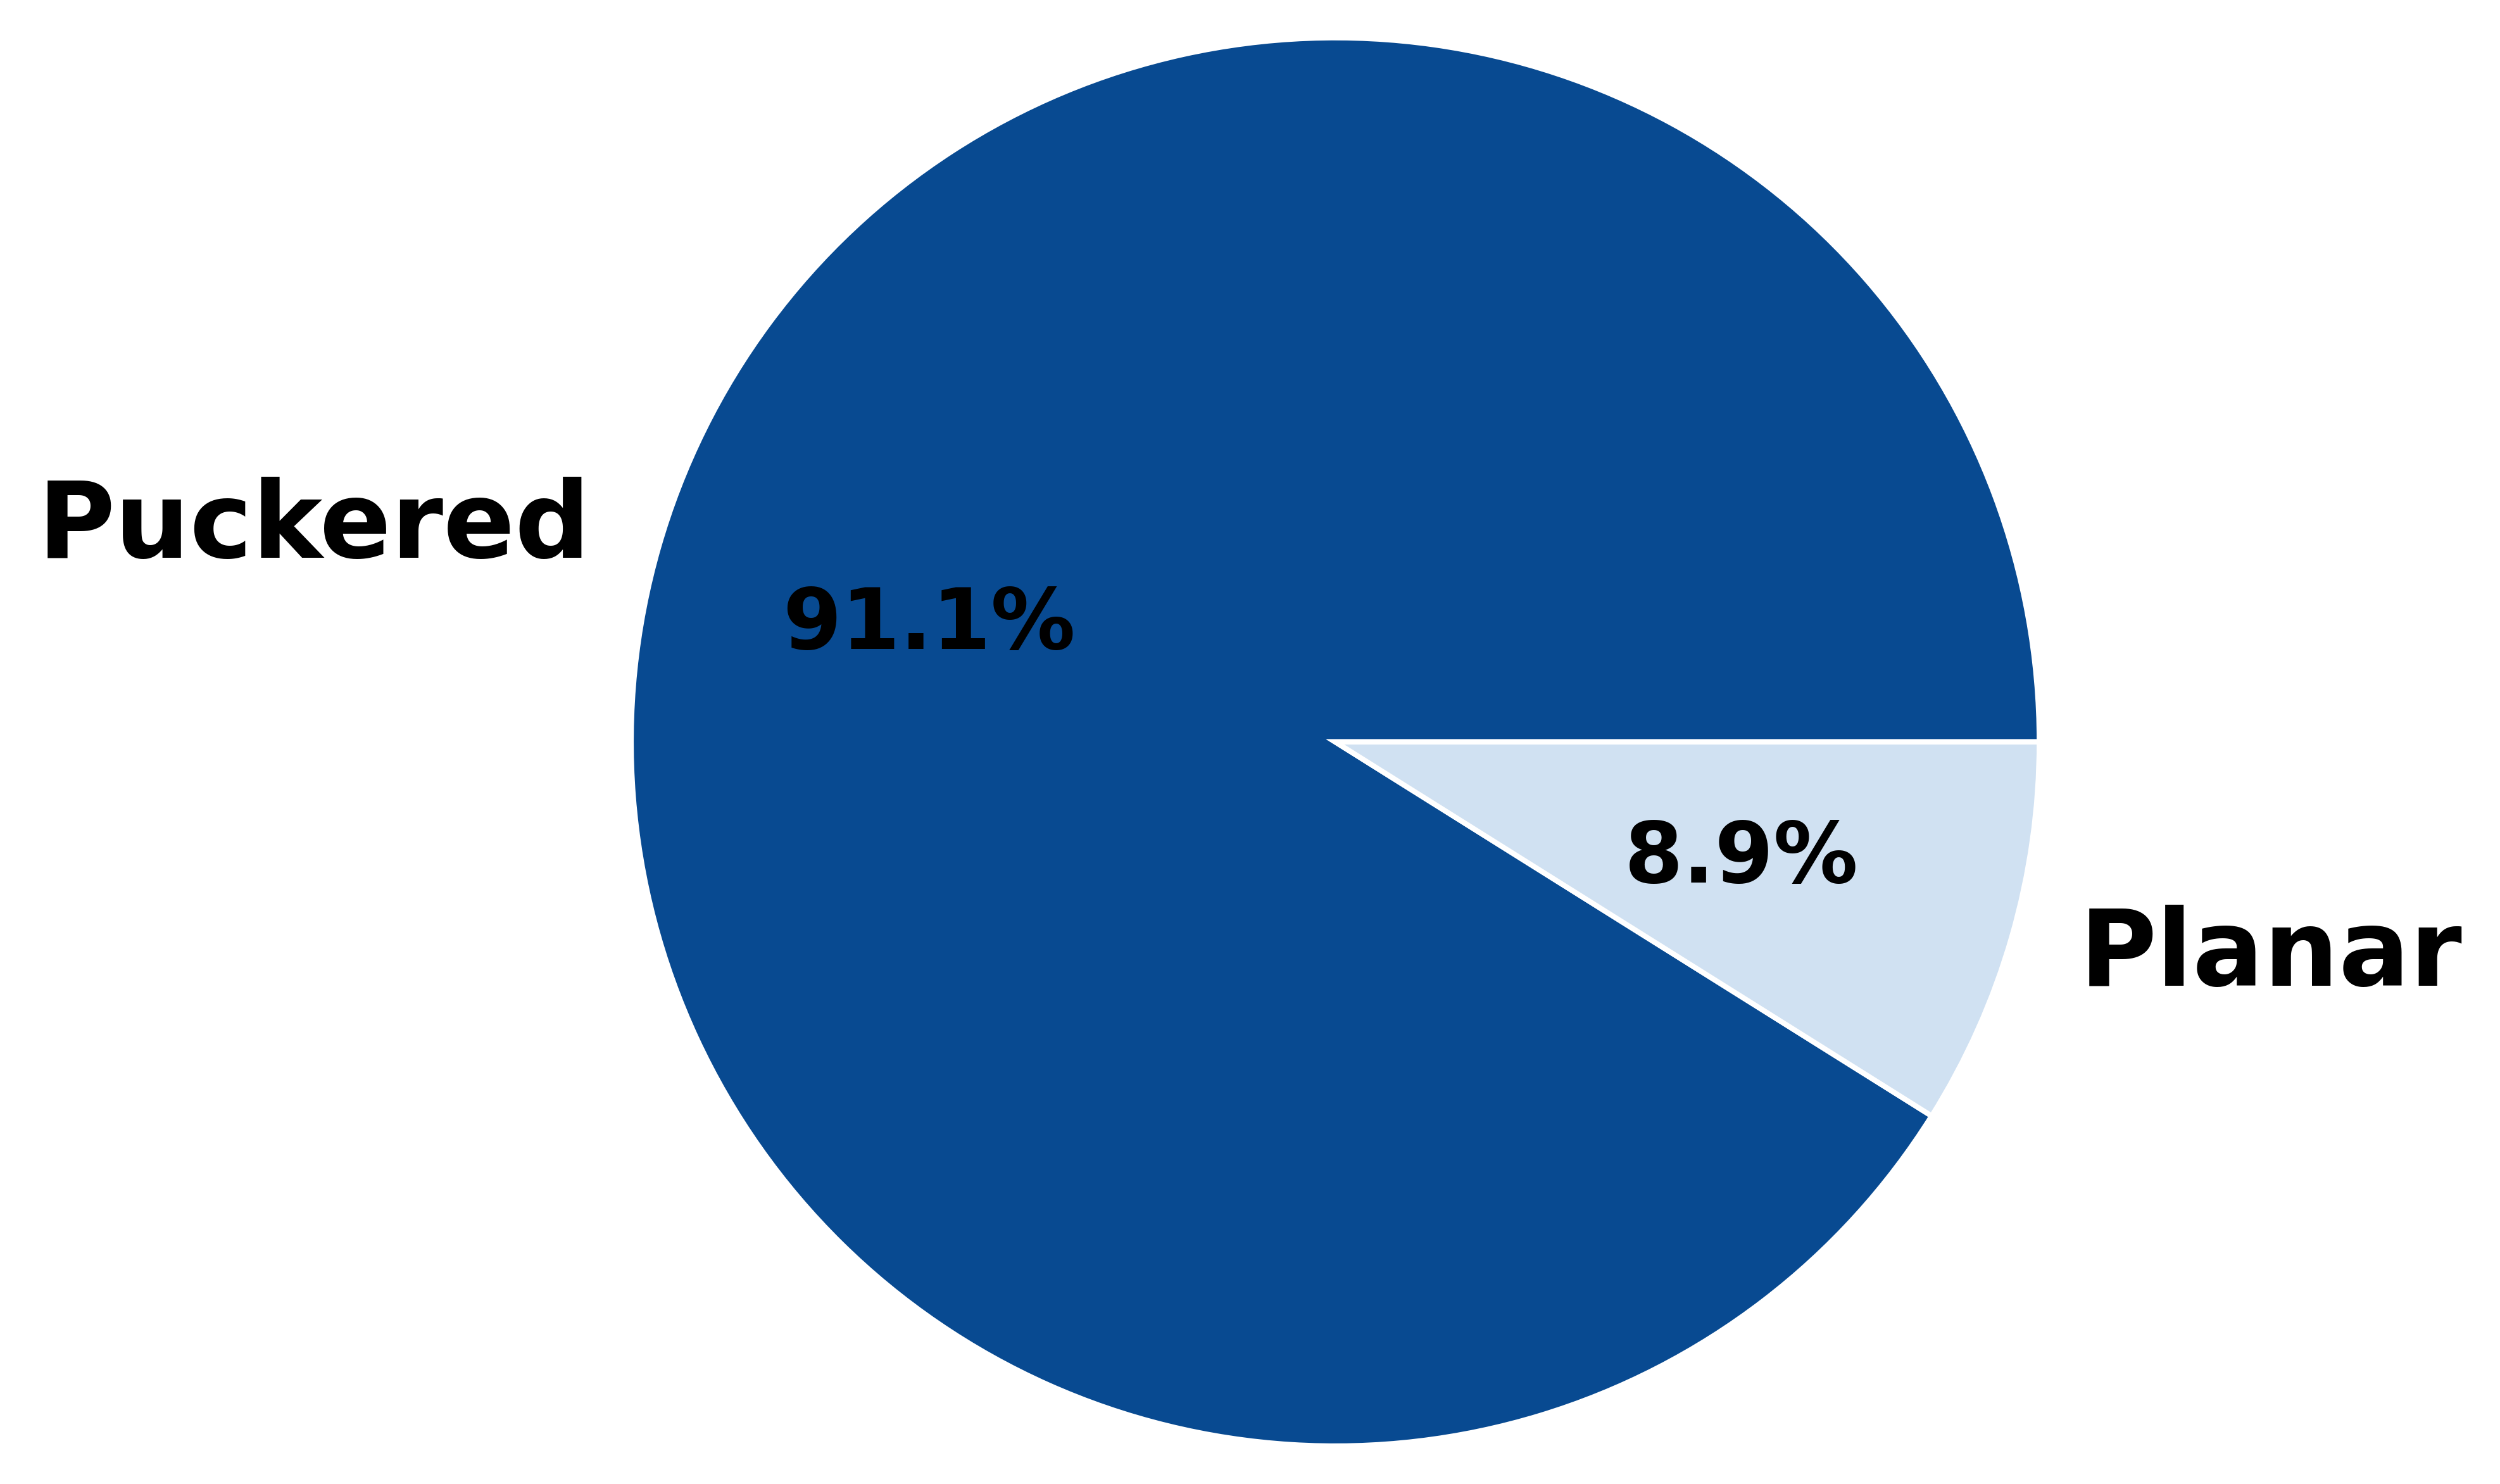

In [7]:
counts = df["puckering"].value_counts()
labels = counts.index
sizes = counts.values


colors = plt.get_cmap('Blues')(np.linspace(0.9, 0.2, len(sizes)))
fig, ax = plt.subplots(figsize=(8,8),dpi=600)
patches, texts, autotexts = ax.pie(sizes, 
       labels=labels, 
       radius=2, 
       autopct='%1.1f%%', 
       shadow=False, 
       startangle=0, 
       colors=colors, 
       wedgeprops={"linewidth": 1, "edgecolor": "white"}
      )
for text in texts:
    text.set_fontsize(20)
    text.set_fontweight("bold")
    
for autotext in autotexts:
    autotext.set_fontsize(16)
    autotext.set_fontweight("bold")
    
plt.tight_layout(pad=-3.6)
plt.savefig("pie_chart.tif",dpi=600)
plt.show()

In [8]:
df["bit_vector"] = df["atom_counts"].apply(atom_dict_to_bitvector)

In [9]:
df

,Unnamed: 0.1,Unnamed: 0,atom_counts,puckering,bit_vector
0,0,0,"{'Ba': 2, 'Sb': 1}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1,"{'Tc': 1, 'Te': 2}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,2,"{'Au': 1, 'Br': 1}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,3,"{'Ti': 3, 'Se': 2}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,4,"{'Au': 2, 'Se': 2}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
4067,4067,4067,"{'Sn': 2, 'N': 2}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, ..."
4068,4068,4068,"{'Sn': 1, 'Bi': 1}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4069,4069,4069,"{'C': 2, 'Sb': 2}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ..."
4070,4070,4070,"{'Ba': 2, 'P': 6}",Puckered,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
print(len(df))
print(len(df.loc[df['puckering'] == 'Planar']))
print(len(df.loc[df['puckering'] == 'Puckered']))

4072
363
3709


In [11]:
X = np.array(df["bit_vector"].values.tolist())
y = df["puckering"].values

In [12]:
X.shape

(4072, 118)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = SVC(class_weight={
    "Planar":2.5,
    "Puckered":1.0
},random_state=0, probability=True)

In [15]:
model.fit(X_train, y_train)

SVC(class_weight={'Planar': 2.5, 'Puckered': 1.0}, probability=True,
    random_state=0)

In [16]:
joblib.dump(model, 'model.pkl')

y_pred_prob = model.predict_proba(X_test)
y_train_pred_prob = model.predict_proba(X_train)

In [17]:
threshold = 0.65
y_pred = predict_classes(y_pred_prob, class_names=model.classes_, threshold=threshold)
y_train_pred = predict_classes(y_train_pred_prob, class_names=model.classes_, threshold=threshold)

In [18]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

      Planar       0.85      0.69      0.76       291
    Puckered       0.97      0.99      0.98      2966

    accuracy                           0.96      3257
   macro avg       0.91      0.84      0.87      3257
weighted avg       0.96      0.96      0.96      3257



In [19]:
print(balanced_accuracy_score(y_train, y_train_pred))

0.8394606224496179


In [20]:
print(matthews_corrcoef(y_train, y_train_pred))

0.7469991413492486


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Planar       0.83      0.67      0.74        72
    Puckered       0.97      0.99      0.98       743

    accuracy                           0.96       815
   macro avg       0.90      0.83      0.86       815
weighted avg       0.96      0.96      0.96       815



In [22]:
print(balanced_accuracy_score(y_test, y_pred))

0.8266038582323911


In [23]:
print(matthews_corrcoef(y_test, y_pred))

0.7210245050022706


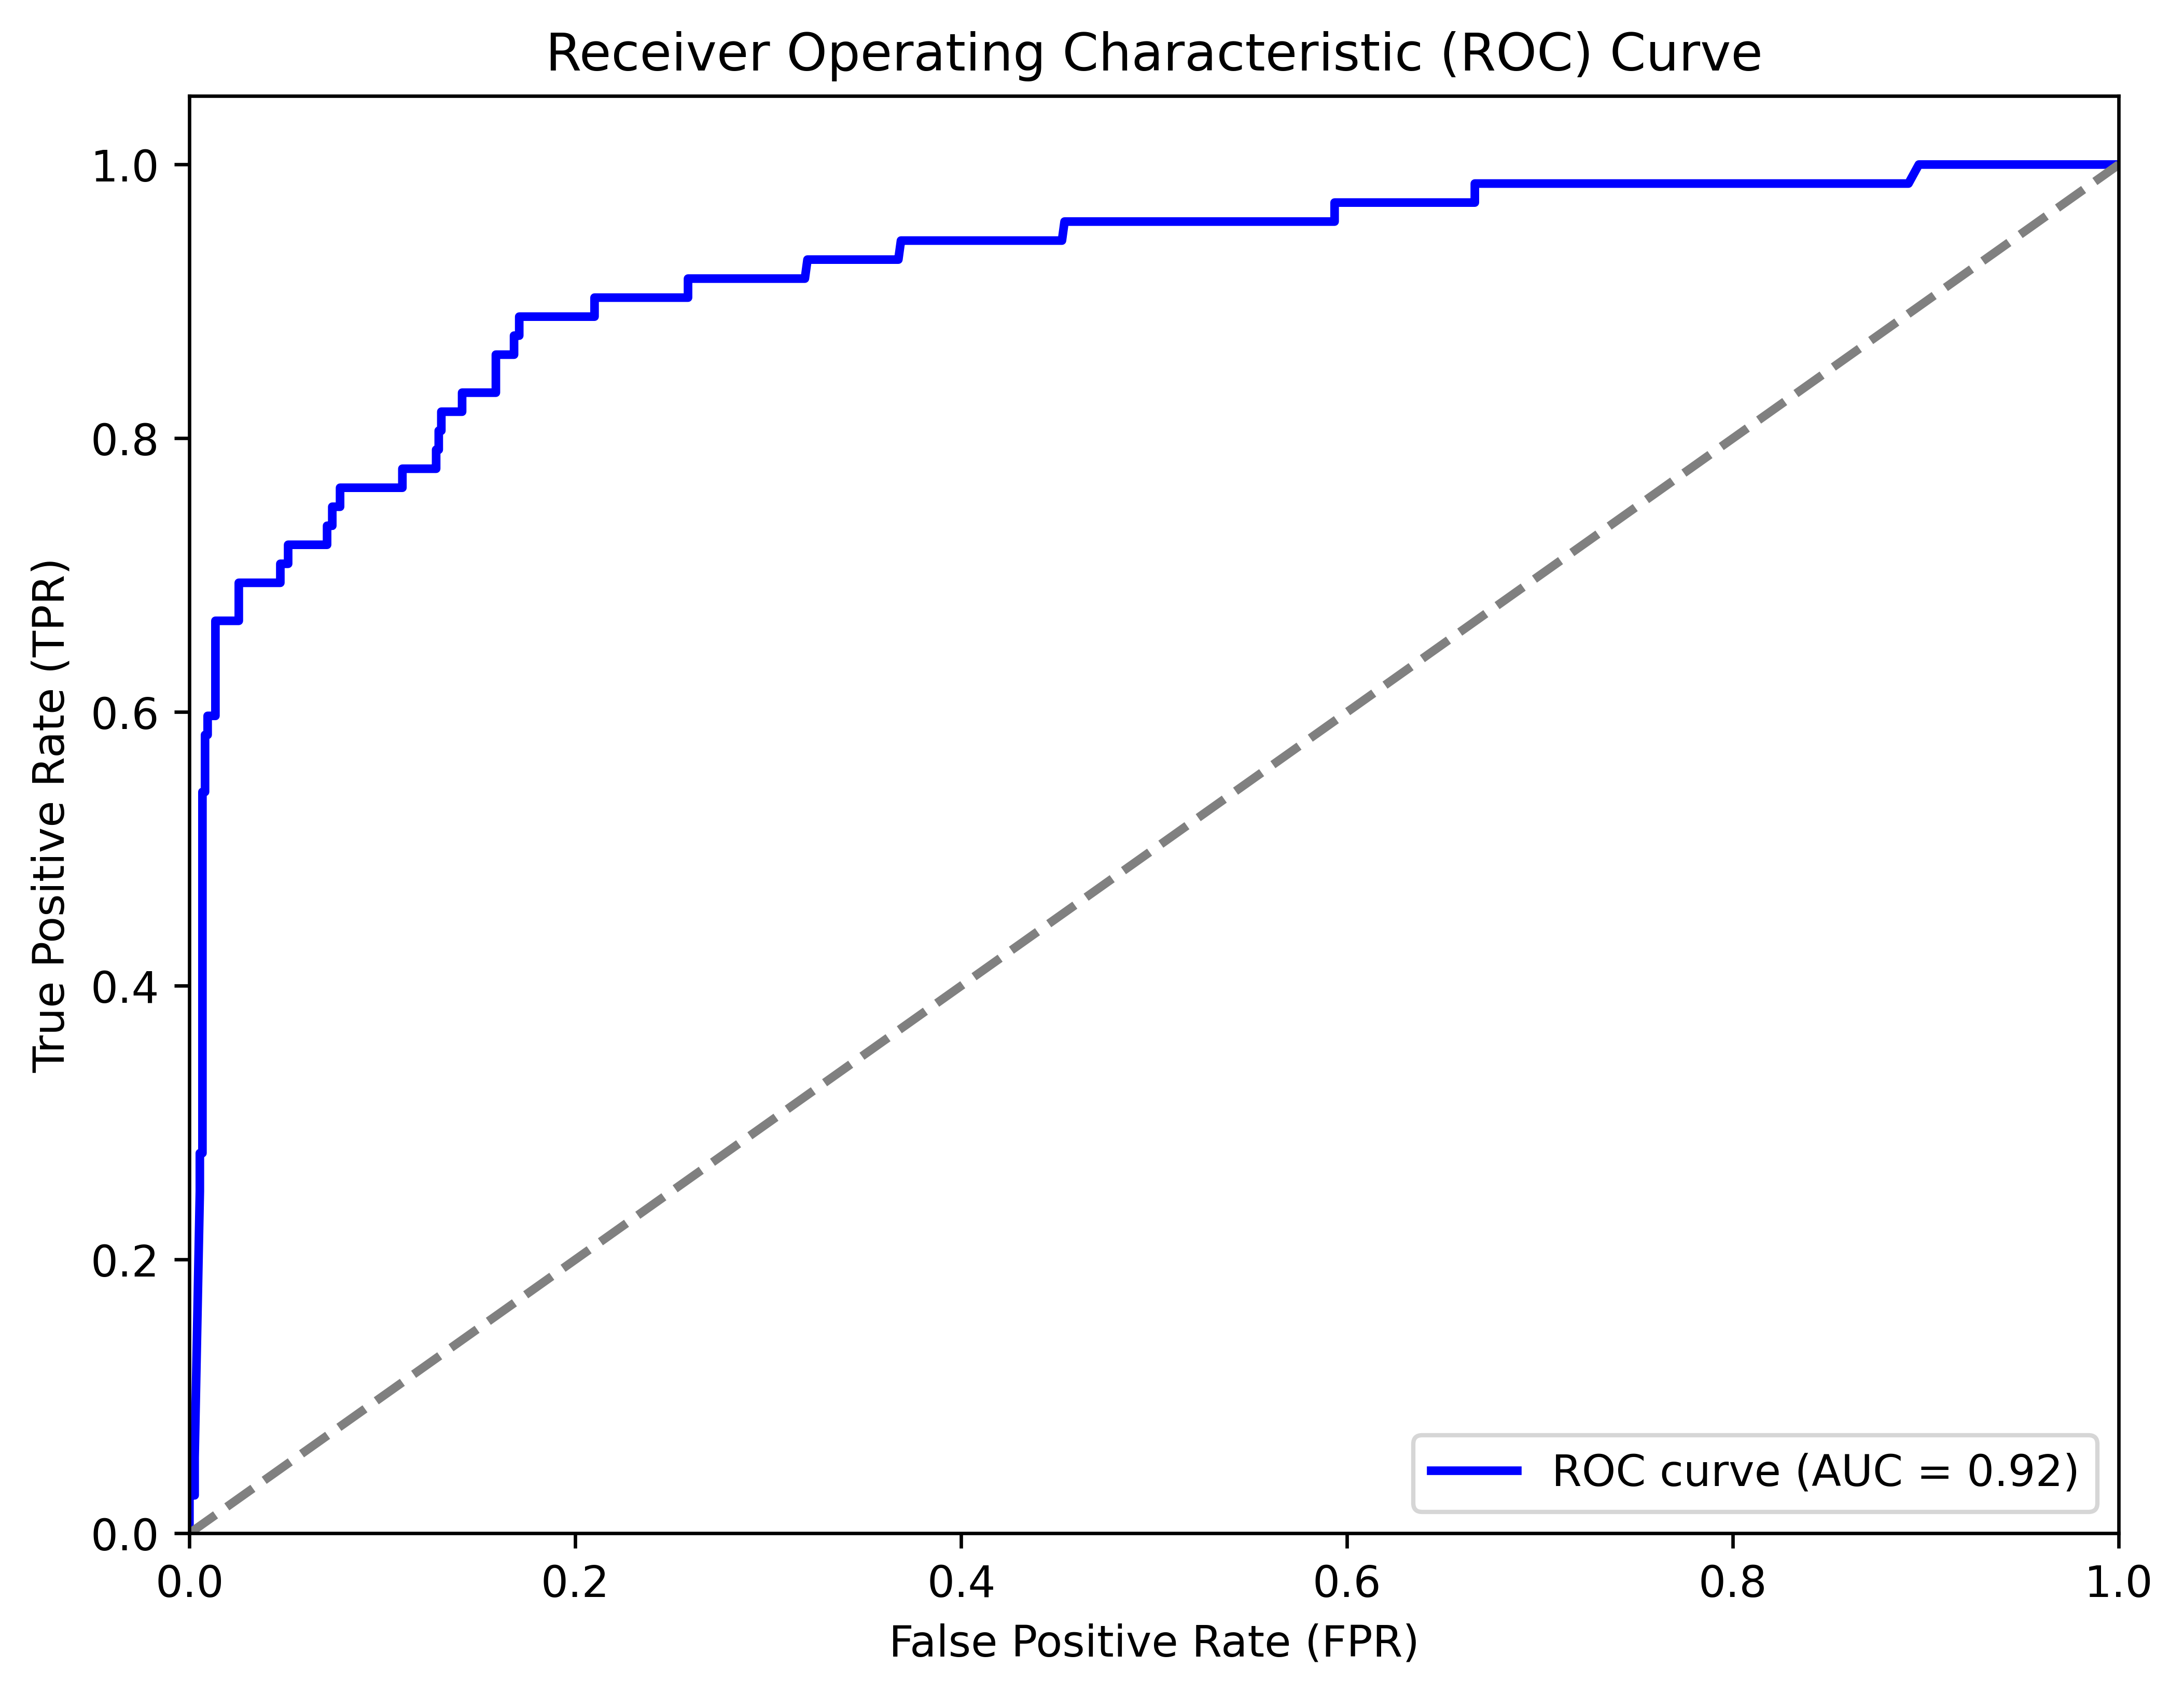

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

pos_label = "Planar"
planar_index = np.argmax(model.classes_ == pos_label)
y_scores = model.predict_proba(X_test)[:, planar_index]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=pos_label)  # y_scores = model.predict_proba(X_test)[:, 1]
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6), dpi=600)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# plt.grid(True)
plt.savefig("roc.svg", dpi=600)
plt.show()

In [25]:
model.classes_

array(['Planar', 'Puckered'], dtype=object)

In [26]:
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar",
    "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr",
    "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd",
    "In", "Sn", "Sb", "Te", "I", "Xe",
    "Cs", "Ba",
    "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
    "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn",
    "Fr", "Ra",
    "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr",
    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn",
    "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

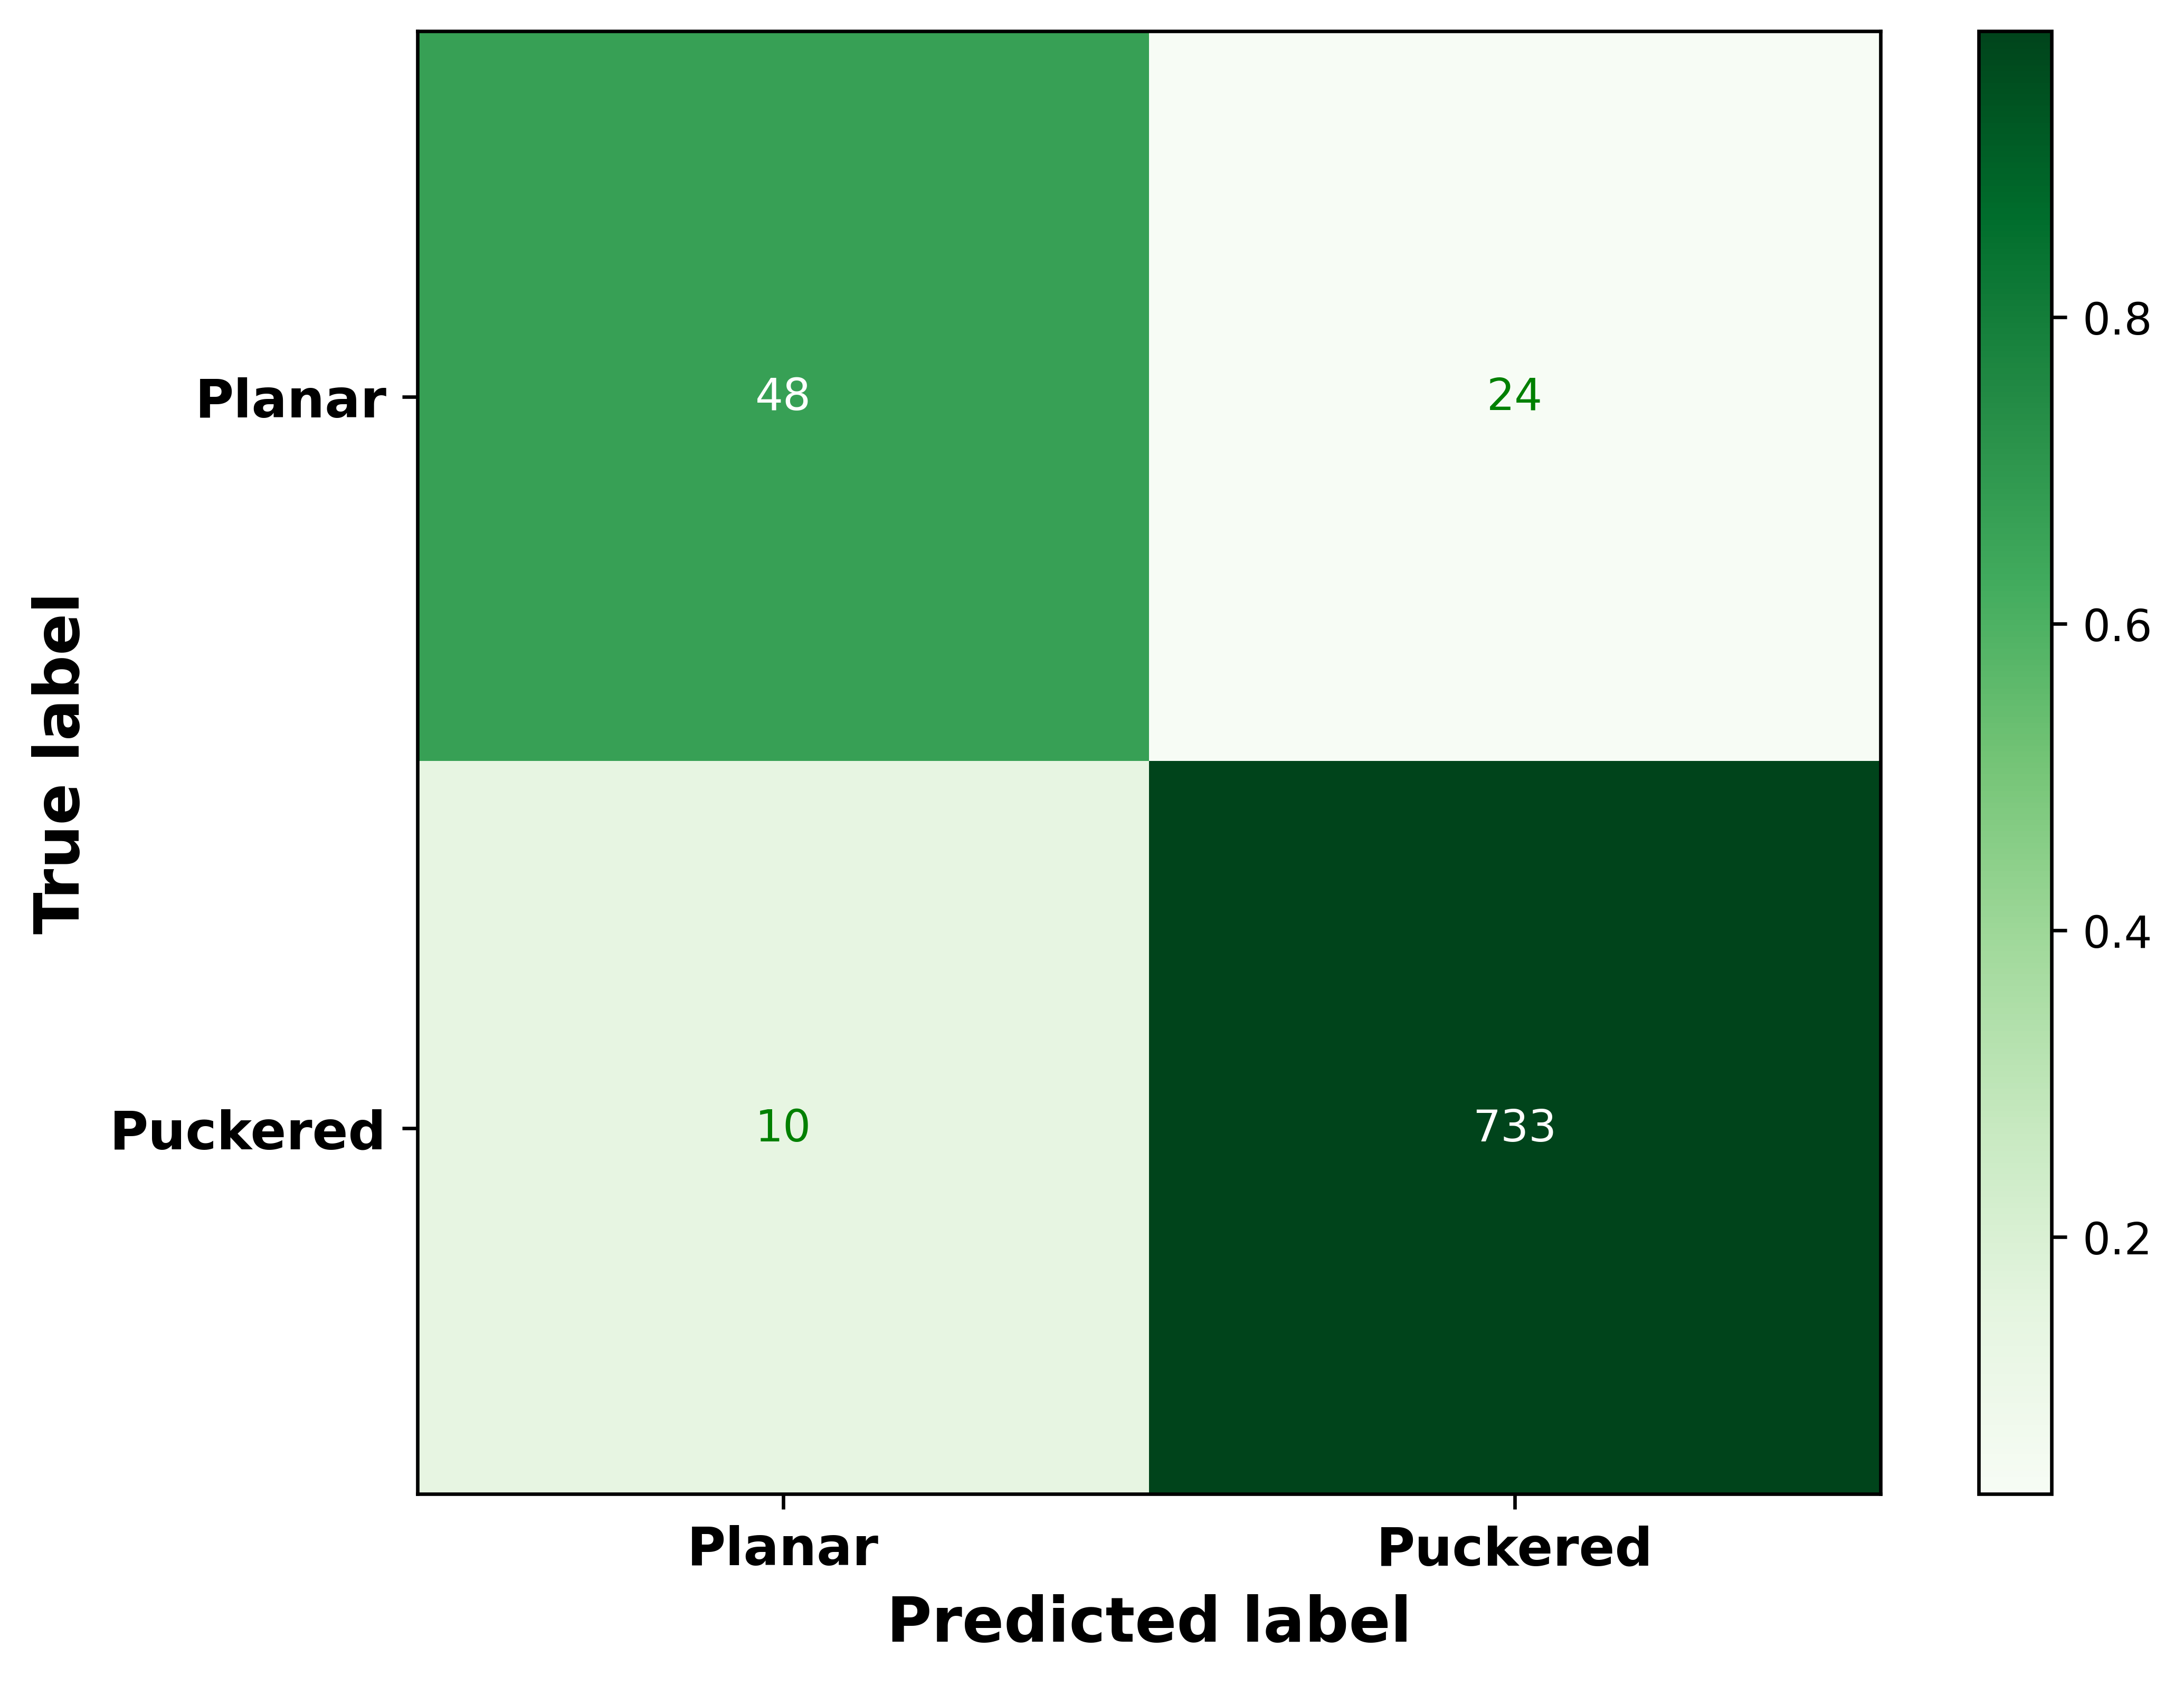

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

classes = model.classes_
accuracies = cm/cm.sum(1)
fig, ax = plt.subplots(figsize=(8,6), dpi=600)
cb = ax.imshow(accuracies, cmap='Greens')
plt.xticks(range(len(classes)), classes, rotation=0, fontweight="bold", fontsize=12)
plt.yticks(range(len(classes)), classes, fontweight="bold", fontsize=12)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        ax.annotate(f'{cm[j,i]}', (i,j), 
                    color=color, va='center', ha='center')

plt.colorbar(cb, ax=ax)
plt.xlabel("Predicted label", fontweight="bold", fontsize=14)
plt.ylabel("True label", fontweight="bold", fontsize=14)
plt.savefig("confusion.svg", dpi=600)
plt.show()

In [28]:
background = shap.sample(X_train, nsamples=600, random_state=0)
explainer = shap.KernelExplainer(model=model.predict_proba, data=background, features=atomic_symbols)
background_test, _ = train_test_split(X_test, train_size=400, stratify=y_test, random_state=0)
shap_values = explainer.shap_values(background_test)

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

In [29]:
np.save("shap_values.npy", shap_values)

# Load later
loaded_shap_values = np.load("shap_values.npy", allow_pickle=True)

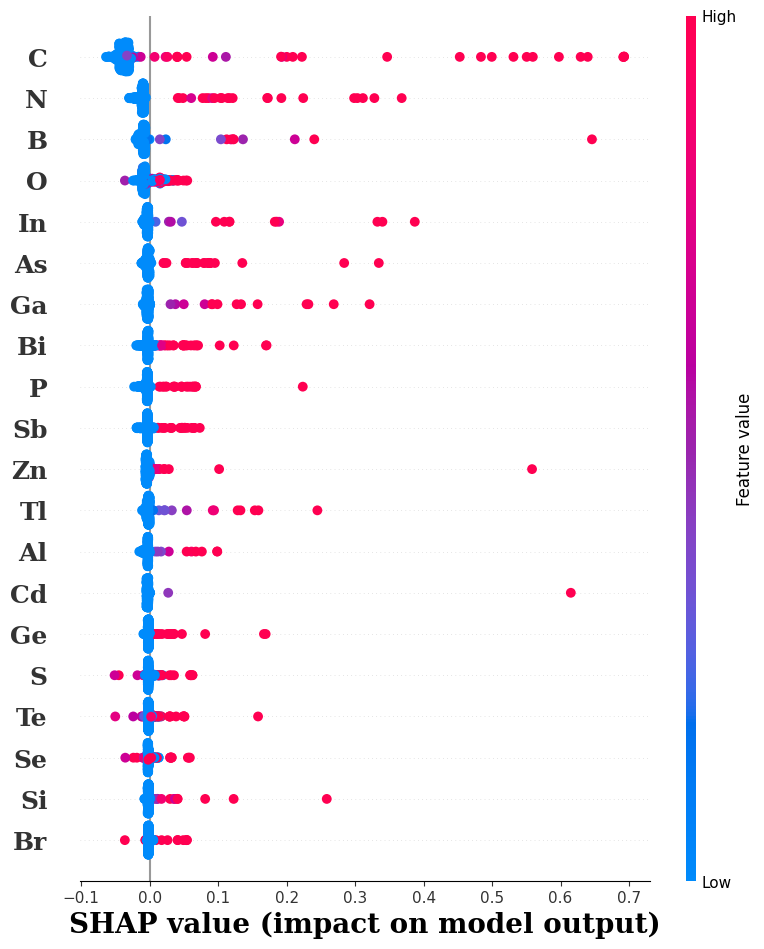

In [30]:
shap.summary_plot(
    shap_values[0],
    background_test,
    feature_names=atomic_symbols,
    show=False
)

ax = plt.gca()

for collection in ax.collections:
    collection.set_sizes([50])

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(18)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily("serif") 

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=20, fontweight='bold', fontfamily="serif")
ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold', fontfamily="serif")
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold', fontfamily="serif")

plt.savefig("shap_summary.svg", bbox_inches='tight', dpi=600)

In [31]:
model.classes_

array(['Planar', 'Puckered'], dtype=object)

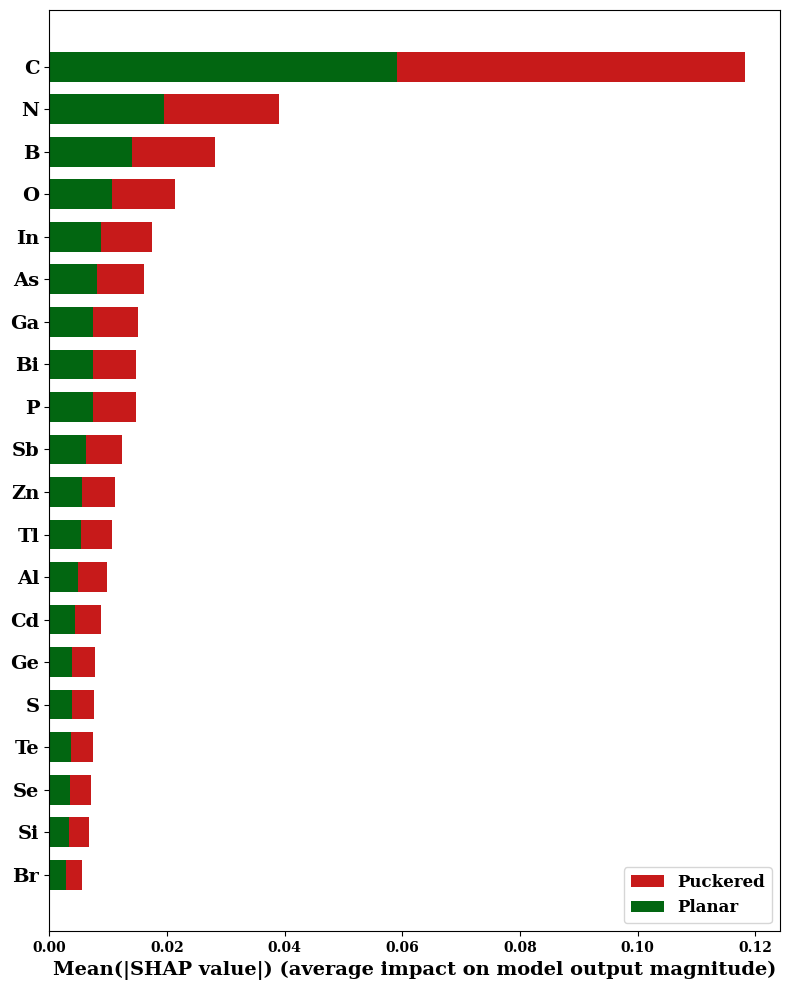

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'bold'

# Compute mean(|SHAP|) per feature for each class
mean_abs_shap_class0 = np.abs(shap_values[0]).mean(axis=0)
mean_abs_shap_class1 = np.abs(shap_values[1]).mean(axis=0)

# Sort features by total importance
total_importance = mean_abs_shap_class0 + mean_abs_shap_class1
sorted_idx = np.argsort(total_importance)[::-1]

# Take top 20
top_n = 20
sorted_idx = sorted_idx[:top_n]

# Apply sorting
features_sorted = [atomic_symbols[i] for i in sorted_idx]
class0_sorted = mean_abs_shap_class0[sorted_idx]
class1_sorted = mean_abs_shap_class1[sorted_idx]

# Plot
bar_width = 0.7
x = np.arange(len(features_sorted))

plt.figure(figsize=(8, 10))
plt.barh(x, class0_sorted+class1_sorted, height=bar_width, color='#c71a1a', label=model.classes_[1])
plt.barh(x, class0_sorted, height=bar_width, color='#026611', label=model.classes_[0])


# Customize axes
plt.yticks(x, features_sorted, fontsize=14, fontweight='bold')
plt.xlabel("Mean(|SHAP value|) (average impact on model output magnitude)", fontsize=14, fontweight='bold')
# plt.title("Top 20 SHAP Feature Importances by Class", fontsize=18, fontweight='bold')
plt.legend(fontsize=12)
plt.gca().invert_yaxis()  # most important features on top

# Save
plt.tight_layout()
plt.savefig("custom_shap_barplot.png", dpi=600)
plt.savefig("custom_shap_barplot.svg", dpi=600)
plt.show()


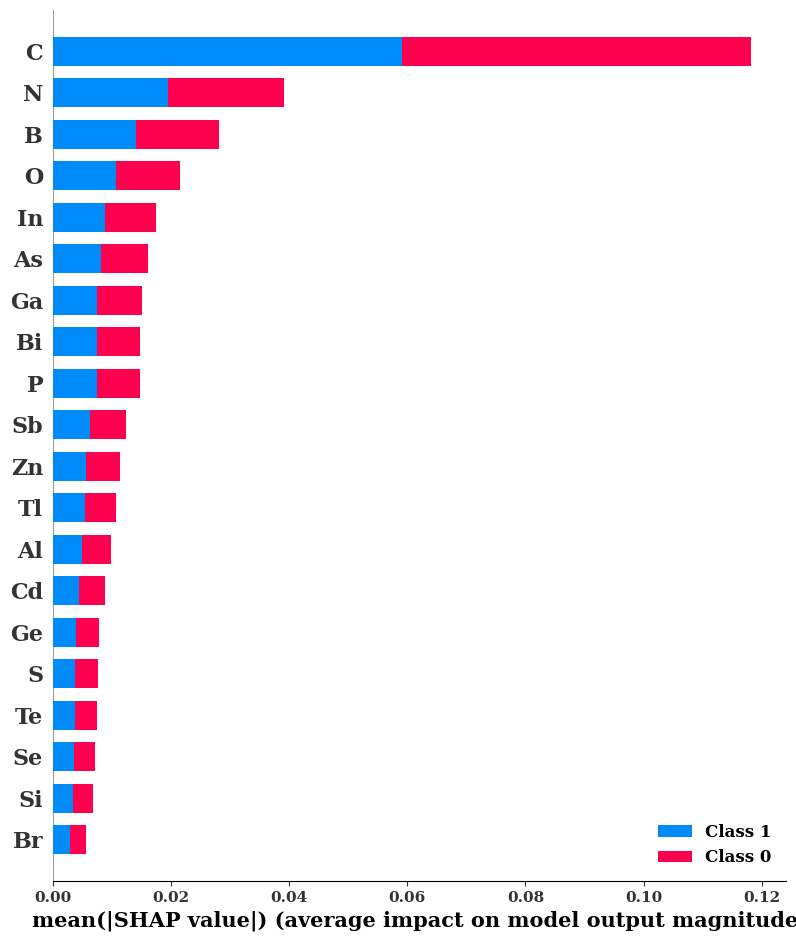

In [33]:
fig = shap.summary_plot(
    shap_values,
    background_test,
    plot_type="bar",
    feature_names=atomic_symbols,
    show=False
)

ax = plt.gca()

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=15, fontweight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')

plt.savefig("shap_summary_bar.png", dpi=600, bbox_inches="tight")  # Save as PNG
plt.savefig("shap_summary_bar.svg", dpi=600, bbox_inches="tight")